## Load Libraries

Source: 
    - https://tensorflow.rstudio.com/blog/keras-customer-churn.html

In [2]:
# Load libraries
library(keras)
library(lime)
library(tidyquant)
library(rsample)
library(recipes)
library(yardstick)
library(corrr)

Loading required package: lubridate

Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date

Loading required package: PerformanceAnalytics
Loading required package: xts
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Attaching package: ‘PerformanceAnalytics’

The following object is masked from ‘package:graphics’:

    legend

Loading required package: quantmod
Loading required package: TTR
Version 0.4-0 included new data defaults. See ?getSymbols.
Loading required package: tidyverse
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.4.1     ✔ dplyr   0.7.4
✔ tidyr   0.7.2     ✔ stringr 1.2.0
✔ readr   1.1.1     ✔ forcats 0.2.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ lubridate::as.difftime() masks base::as.difftime()
✖ lubridate::date

## Import Data

In [41]:
base_dir <- "/Users/DesyFellow/Desktop/CaseStudy/Kreditech/"
churn_data_raw <- read_csv(paste(base_dir,"WA_Fn-UseC_-Telco-Customer-Churn.csv", sep=""))
glimpse(churn_data_raw)

Parsed with column specification:
cols(
  .default = col_character(),
  SeniorCitizen = col_integer(),
  tenure = col_integer(),
  MonthlyCharges = col_double(),
  TotalCharges = col_double()
)
See spec(...) for full column specifications.


Observations: 7,043
Variables: 21
$ customerID       <chr> "7590-VHVEG", "5575-GNVDE", "3668-QPYBK", "7795-CF...
$ gender           <chr> "Female", "Male", "Male", "Male", "Female", "Femal...
$ SeniorCitizen    <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
$ Partner          <chr> "Yes", "No", "No", "No", "No", "No", "No", "No", "...
$ Dependents       <chr> "No", "No", "No", "No", "No", "No", "Yes", "No", "...
$ tenure           <int> 1, 34, 2, 45, 2, 8, 22, 10, 28, 62, 13, 16, 58, 49...
$ PhoneService     <chr> "No", "Yes", "Yes", "No", "Yes", "Yes", "Yes", "No...
$ MultipleLines    <chr> "No phone service", "No", "No", "No phone service"...
$ InternetService  <chr> "DSL", "DSL", "DSL", "DSL", "Fiber optic", "Fiber ...
$ OnlineSecurity   <chr> "No", "Yes", "Yes", "Yes", "No", "No", "No", "Yes"...
$ OnlineBackup     <chr> "Yes", "No", "Yes", "No", "No", "No", "Yes", "No",...
$ DeviceProtection <chr> "No", "Yes", "No", "Yes", "No", "Yes", "No", "No",...
$ TechSupport     

## Preprocess Data

 we "prune" the data, which is nothing more than removing unnecessary columns and rows. Then we split into training and testing sets. After that we explore the training set to uncover transformations that will be needed for deep learning.
 
PRUNE THE DATA

The data has a few columns and rows we’d like to remove:

- The “customerID” column is a unique identifier for each observation that isn’t needed for modeling. We can de-select this column.

- The data has 11 NA values all in the “TotalCharges” column. Because it’s such a small percentage of the total population (99.8% complete cases), we can drop these observations with the drop_na() function from tidyr. Note that these may be customers that have not yet been charged, and therefore an alternative is to replace with zero or -99 to segregate this population from the rest.

- My preference is to have the target in the first column so we’ll include a final select() ooperation to do so.

We’ll perform the cleaning operation with one tidyverse pipe (%>%) chain.

In [6]:
# Remove unnecessary data
churn_data_tbl <- churn_data_raw %>%
  select(-customerID) %>%
  drop_na() %>%
  select(Churn, everything())
    
glimpse(churn_data_tbl) #There are 7,032 observations and 20 variables

Observations: 7,032
Variables: 20
$ Churn            <chr> "No", "No", "Yes", "No", "Yes", "Yes", "No", "No",...
$ gender           <chr> "Female", "Male", "Male", "Male", "Female", "Femal...
$ SeniorCitizen    <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
$ Partner          <chr> "Yes", "No", "No", "No", "No", "No", "No", "No", "...
$ Dependents       <chr> "No", "No", "No", "No", "No", "No", "Yes", "No", "...
$ tenure           <int> 1, 34, 2, 45, 2, 8, 22, 10, 28, 62, 13, 16, 58, 49...
$ PhoneService     <chr> "No", "Yes", "Yes", "No", "Yes", "Yes", "Yes", "No...
$ MultipleLines    <chr> "No phone service", "No", "No", "No phone service"...
$ InternetService  <chr> "DSL", "DSL", "DSL", "DSL", "Fiber optic", "Fiber ...
$ OnlineSecurity   <chr> "No", "Yes", "Yes", "Yes", "No", "No", "No", "Yes"...
$ OnlineBackup     <chr> "Yes", "No", "Yes", "No", "No", "No", "Yes", "No",...
$ DeviceProtection <chr> "No", "Yes", "No", "Yes", "No", "Yes", "No", "No",...
$ TechSupport     

## SPLIT INTO TRAIN/TEST SETS

We have a new package, rsample, which is very useful for sampling methods. It has the initial_split() function for splitting data sets into training and testing sets. The return is a special rsplit object.

In [7]:
# Split test/training sets
set.seed(100)
train_test_split <- initial_split(churn_data_tbl, prop = 0.8)
train_test_split

<5626/1406/7032>

In [8]:
# Retrieve train and test sets
train_tbl <- training(train_test_split)
test_tbl  <- testing(train_test_split) 

## EXPLORATION: WHAT TRANSFORMATION STEPS ARE NEEDED FOR ML?

This phase of the analysis is often called exploratory analysis, but basically we are trying to answer the question, “What steps are needed to prepare for ML?” The key concept is knowing what transformations are needed to run the algorithm most effectively. Artificial Neural Networks are best when the data is one-hot encoded, scaled and centered. In addition, other transformations may be beneficial as well to make relationships easier for the algorithm to identify. 

### DISCRETIZE THE “TENURE” FEATURE

Numeric features like age, years worked, length of time in a position can generalize a group (or cohort). We see this in marketing a lot (think “millennials”, which identifies a group born in a certain timeframe). The “tenure” feature falls into this category of numeric features that can be discretized into groups.

We can split into six cohorts that divide up the user base by tenure in roughly one year (12 month) increments. This should help the ML algorithm detect if a group is more/less susceptible to customer churn.

#### TRANSFORM THE “TOTALCHARGES” FEATURE

What we don’t like to see is when a lot of observations are bunched within a small part of the range.

Pro Tip: A quick test is to see if the log transformation increases the magnitude of the correlation between “TotalCharges” and “Churn”

In [9]:
# Determine if log transformation improves correlation 
# between TotalCharges and Churn
train_tbl %>%
  select(Churn, TotalCharges) %>%
  mutate(
      Churn = Churn %>% as.factor() %>% as.numeric(),
      LogTotalCharges = log(TotalCharges)
      ) %>%
  correlate() %>%
  focus(Churn) %>%
  fashion()

rowname,Churn
TotalCharges,-.20
LogTotalCharges,-.25


The correlation between “Churn” and “LogTotalCharges” is greatest in magnitude indicating the log transformation should improve the accuracy of the ANN model we build. Therefore, we should perform the log transformation.

### ONE-HOT ENCODING

One-hot encoding is the process of converting categorical data to sparse data, which has columns of only zeros and ones (this is also called creating “dummy variables” or a “design matrix”). All non-numeric data will need to be converted to dummy variables. This is simple for binary Yes/No data because we can simply convert to 1’s and 0’s. It becomes slightly more complicated with multiple categories, which requires creating new columns of 1’s and 0`s for each category (actually one less). We have four features that are multi-category: Contract, Internet Service, Multiple Lines, and Payment Method.

In [10]:
# Create recipe
rec_obj <- recipe(Churn ~ ., data = train_tbl) %>%
  step_discretize(tenure, options = list(cuts = 6)) %>%
  step_log(TotalCharges) %>%
  step_dummy(all_nominal(), -all_outcomes()) %>%
  step_center(all_predictors(), -all_outcomes()) %>%
  step_scale(all_predictors(), -all_outcomes()) %>%
  prep(data = train_tbl)

### STEP 1: CREATE A RECIPE

In [11]:
# Print the recipe object
rec_obj

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor         19

Training data contained 5626 data points and no missing data.

Operations:

Dummy variables from tenure [trained]
Log transformation on TotalCharges [trained]
Dummy variables from gender, Partner, Dependents, tenure, ... [trained]
Centering for SeniorCitizen, MonthlyCharges, ... [trained]
Scaling for SeniorCitizen, MonthlyCharges, ... [trained]

### STEP 2: BAKING WITH YOUR RECIPE

In [13]:
# Predictors
x_train_tbl <- bake(rec_obj, newdata = train_tbl) %>% select(-Churn)
x_test_tbl  <- bake(rec_obj, newdata = test_tbl) %>% select(-Churn)

glimpse(x_train_tbl)

Observations: 5,626
Variables: 35
$ SeniorCitizen                         <dbl> -0.4351959, -0.4351959, -0.43...
$ MonthlyCharges                        <dbl> -1.157597168, -0.260133339, -...
$ TotalCharges                          <dbl> -2.275819130, 0.389259098, 0....
$ gender_Male                           <dbl> -1.0016900, 0.9981354, 0.9981...
$ Partner_Yes                           <dbl> 1.0262054, -0.9742906, -0.974...
$ Dependents_Yes                        <dbl> -0.6507747, -0.6507747, -0.65...
$ tenure_bin1                           <dbl> 2.1677790, -0.4612196, -0.461...
$ tenure_bin2                           <dbl> -0.4389453, -0.4389453, -0.43...
$ tenure_bin3                           <dbl> -0.4481273, -0.4481273, -0.44...
$ tenure_bin4                           <dbl> -0.4509837, 2.2169809, 2.2169...
$ tenure_bin5                           <dbl> -0.4498419, -0.4498419, -0.44...
$ tenure_bin6                           <dbl> -0.4337508, -0.4337508, -0.43...
$ PhoneService_Yes

### STEP 3: DON’T FORGET THE TARGET

In [14]:
# Response variables for training and testing sets
y_train_vec <- ifelse(pull(train_tbl, Churn) == "Yes", 1, 0)
y_test_vec  <- ifelse(pull(test_tbl, Churn) == "Yes", 1, 0)

## Model Customer Churn With Keras

We’re going to build a special class of ANN called a Multi-Layer Perceptron (MLP).

In [15]:
# Building our Artificial Neural Network
model_keras <- keras_model_sequential()

model_keras %>% 
  
  # First hidden layer
  layer_dense(
    units              = 16, 
    kernel_initializer = "uniform", 
    activation         = "relu", 
    input_shape        = ncol(x_train_tbl)) %>% 
  
  # Dropout to prevent overfitting
  layer_dropout(rate = 0.1) %>%
  
  # Second hidden layer
  layer_dense(
    units              = 16, 
    kernel_initializer = "uniform", 
    activation         = "relu") %>% 
  
  # Dropout to prevent overfitting
  layer_dropout(rate = 0.1) %>%
  
  # Output layer
  layer_dense(
    units              = 1, 
    kernel_initializer = "uniform", 
    activation         = "sigmoid") %>% 
  
  # Compile ANN
  compile(
    optimizer = 'adam',
    loss      = 'binary_crossentropy',
    metrics   = c('accuracy')
  )

keras_model

function (inputs, outputs = NULL) 
{
    keras$models$Model(inputs = unname(inputs), outputs = unname(outputs))
}
<environment: namespace:keras>

In [16]:
# Fit the keras model to the training data
history <- fit(
  object           = model_keras, 
  x                = as.matrix(x_train_tbl), 
  y                = y_train_vec,
  batch_size       = 50, 
  epochs           = 35,
  validation_split = 0.30
)

We can inspect the training history. We want to make sure there is minimal difference between the validation accuracy and the training accuracy.

In [17]:
# Print a summary of the training history
print(history)

Trained on 3,938 samples, validated on 1,688 samples (batch_size=50, epochs=35)
Final epoch (plot to see history):
     acc: 0.8149
    loss: 0.3975
 val_acc: 0.7962
val_loss: 0.4263 


In [ ]:
# Plot the training/validation history of our Keras model
plot(history) 

## MAKING PREDICTIONS

We’ve got a good model based on the validation accuracy. Now let’s make some predictions from our keras model on the test data set, which was unseen during modeling (we use this for the true performance assessment).

- predict_classes(): Generates class values as a matrix of ones and zeros. Since we are dealing with binary classification, we’ll convert the output to a vector.

- predict_proba(): Generates the class probabilities as a numeric matrix indicating the probability of being a class. Again, we convert to a numeric vector because there is only one column output.

In [19]:
# Predicted Class
yhat_keras_class_vec <- predict_classes(object = model_keras, x = as.matrix(x_test_tbl)) %>%
    as.vector()

# Predicted Class Probability
yhat_keras_prob_vec  <- predict_proba(object = model_keras, x = as.matrix(x_test_tbl)) %>%
    as.vector()

### Inspect Performance With Yardstick

In [20]:
# Format test data and predictions for yardstick metrics
estimates_keras_tbl <- tibble(
  truth      = as.factor(y_test_vec) %>% fct_recode(yes = "1", no = "0"),
  estimate   = as.factor(yhat_keras_class_vec) %>% fct_recode(yes = "1", no = "0"),
  class_prob = yhat_keras_prob_vec
)

estimates_keras_tbl

truth,estimate,class_prob
yes,no,0.408011109
yes,yes,0.514871180
no,no,0.005953256
no,no,0.006962879
no,no,0.028106188
no,no,0.091190457
no,yes,0.771699905
no,no,0.469329208
no,no,0.007938888
no,no,0.003572825


In [21]:
# Set yardstick to False since the default is to classify 0 as the positive class instead of 1.
options(yardstick.event_first = FALSE)

In [22]:
# Confusion Table
estimates_keras_tbl %>% conf_mat(truth, estimate)

          Truth
Prediction  no yes
       no  952 165
       yes  97 192

In [23]:
# Accuracy
estimates_keras_tbl %>% metrics(truth, estimate)

accuracy
0.8136558


In [24]:
# AUC
estimates_keras_tbl %>% roc_auc(truth, class_prob)

[1] 0.8515553

In [25]:
# Precision-Recall
tibble(
  precision = estimates_keras_tbl %>% precision(truth, estimate),
  recall    = estimates_keras_tbl %>% recall(truth, estimate)
)

precision,recall
0.6643599,0.5378151


Precision and recall are very important to the business case: The organization is concerned with balancing the cost of targeting and retaining customers at risk of leaving with the cost of inadvertently targeting customers that are not planning to leave (and potentially decreasing revenue from this group). The threshold above which to predict Churn = “Yes” can be adjusted to optimize for the business problem. This becomes an Customer Lifetime Value optimization problem.

#### F1 SCORE

We can also get the F1-score, which is a weighted average between the precision and recall. Machine learning classifier thresholds are often adjusted to maximize the F1-score. However, this is often not the optimal solution to the business problem.

In [26]:
# F1-Statistic
estimates_keras_tbl %>% f_meas(truth, estimate, beta = 1)

[1] 0.5944272

## Explain The Model With LIME

LIME stands for Local Interpretable Model-agnostic Explanations, and is a method for explaining black-box machine learning model classifiers.

The lime package implements LIME in R. One thing to note is that it’s not setup out-of-the-box to work with keras. The good news is with a few functions we can get everything working properly. We’ll need to make two custom functions:

- model_type: Used to tell lime what type of model we are dealing with. It could be classification, regression, survival, etc.

- predict_model: Used to allow lime to perform predictions that its algorithm can interpret.

The first thing we need to do is identify the class of our model object. We do this with the class() function.

In [28]:
print(class(model_keras))

[1] "keras.models.Sequential"         "keras.engine.training.Model"    
[3] "keras.engine.topology.Container" "keras.engine.topology.Layer"    
[5] "python.builtin.object"          


Next we create our model_type() function. It’s only input is x the keras model. The function simply returns “classification”, which tells LIME we are classifying.

In [29]:
# Setup lime::model_type() function for keras
model_type.keras.models.Sequential <- function(x, ...) {
  "classification"
}

Now we can create our predict_model() function, which wraps keras::predict_proba(). The trick here is to realize that it’s inputs must be x a model, newdata a dataframe object (this is important), and type which is not used but can be use to switch the output type. The output is also a little tricky because it must be in the format of probabilities by classification.

In [30]:
# Setup lime::predict_model() function for keras
predict_model.keras.models.Sequential <- function(x, newdata, type, ...) {
  pred <- predict_proba(object = x, x = as.matrix(newdata))
  data.frame(Yes = pred, No = 1 - pred)
}

In [31]:
# Test our predict_model() function
predict_model(x = model_keras, newdata = x_test_tbl, type = 'raw') %>%
  tibble::as_tibble()

Yes,No
0.408011109,0.5919889
0.514871180,0.4851288
0.005953256,0.9940467
0.006962879,0.9930371
0.028106188,0.9718938
0.091190457,0.9088095
0.771699905,0.2283001
0.469329208,0.5306708
0.007938888,0.9920611
0.003572825,0.9964272


In [32]:
# Run lime() on training set
explainer <- lime::lime(
  x              = x_train_tbl, 
  model          = model_keras, 
  bin_continuous = FALSE
)

Now we run the explain() function, which returns our explanation. We set n_labels = 1 because we care about explaining a single class. Setting n_features = 4 returns the top four features that are critical to each case. Finally, setting kernel_width = 0.5 allows us to increase the “model_r2” value by shrinking the localized evaluation.

In [33]:
# Run explain() on explainer
explanation <- lime::explain(
  x_test_tbl[1:10, ], 
  explainer    = explainer, 
  n_labels     = 1, 
  n_features   = 4,
  kernel_width = 0.5
)

## FEATURE IMPORTANCE VISUALIZATION

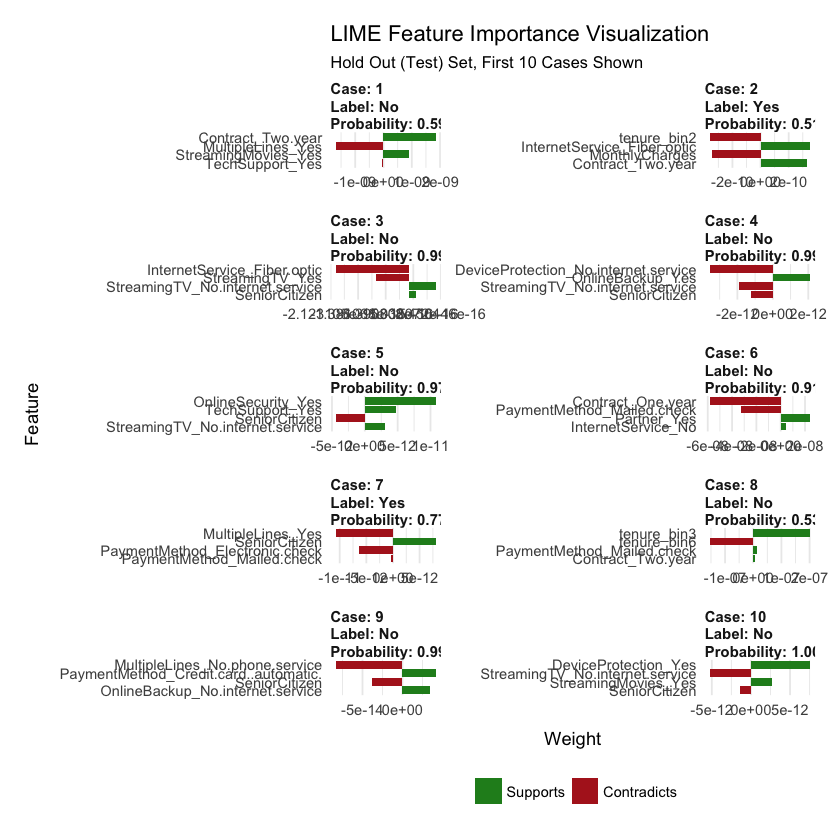

In [34]:
plot_features(explanation) +
  labs(title = "LIME Feature Importance Visualization",
       subtitle = "Hold Out (Test) Set, First 10 Cases Shown")

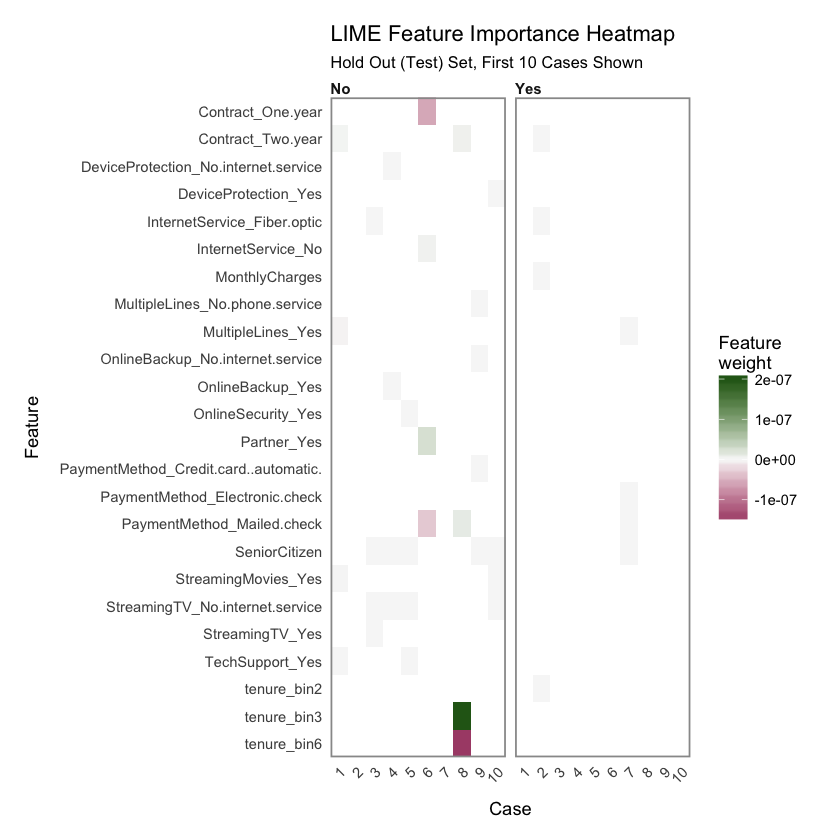

In [35]:
plot_explanations(explanation) +
    labs(title = "LIME Feature Importance Heatmap",
         subtitle = "Hold Out (Test) Set, First 10 Cases Shown")

## Check Explanations With Correlation Analysis

In [36]:
# Feature correlations to Churn
corrr_analysis <- x_train_tbl %>%
  mutate(Churn = y_train_vec) %>%
  correlate() %>%
  focus(Churn) %>%
  rename(feature = rowname) %>%
  arrange(abs(Churn)) %>%
  mutate(feature = as_factor(feature)) 
corrr_analysis

feature,Churn
gender_Male,-0.006690899
tenure_bin3,-0.009557165
MultipleLines_No.phone.service,-0.016950072
PhoneService_Yes,0.016950072
MultipleLines_Yes,0.032103354
StreamingTV_Yes,0.066192594
StreamingMovies_Yes,0.067643871
DeviceProtection_Yes,-0.073301197
tenure_bin4,-0.073371838
PaymentMethod_Mailed.check,-0.080451164


The correlation visualization helps in distinguishing which features are relavant to Churn.

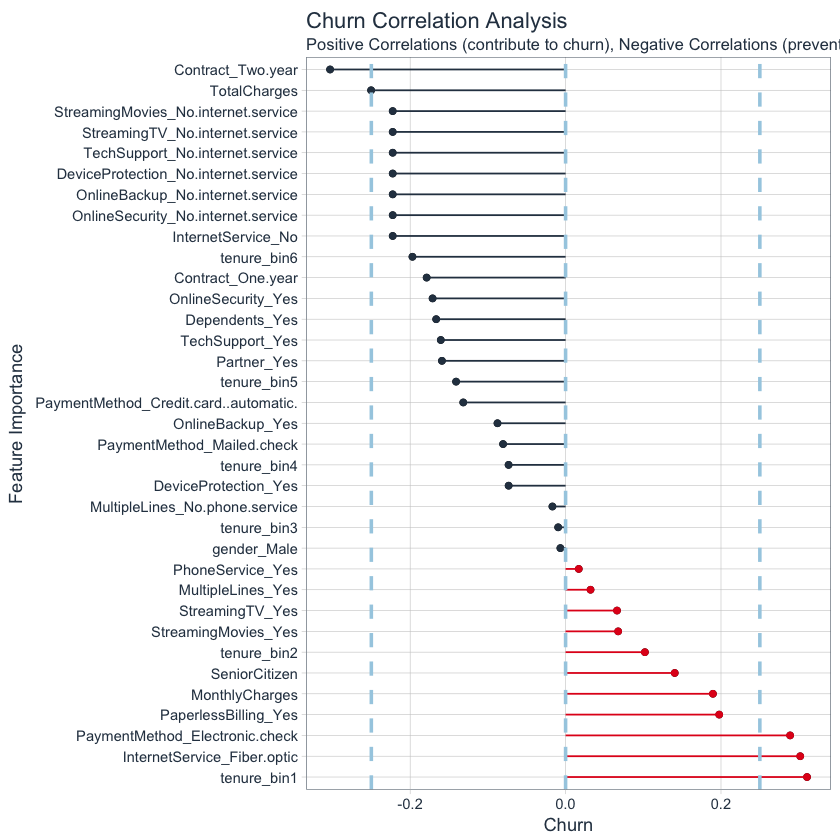

In [37]:
# Correlation visualization
corrr_analysis %>%
  ggplot(aes(x = Churn, y = fct_reorder(feature, desc(Churn)))) +
  geom_point() +
  # Positive Correlations - Contribute to churn
  geom_segment(aes(xend = 0, yend = feature), 
               color = palette_light()[[2]], 
               data = corrr_analysis %>% filter(Churn > 0)) +
  geom_point(color = palette_light()[[2]], 
             data = corrr_analysis %>% filter(Churn > 0)) +
  # Negative Correlations - Prevent churn
  geom_segment(aes(xend = 0, yend = feature), 
               color = palette_light()[[1]], 
               data = corrr_analysis %>% filter(Churn < 0)) +
  geom_point(color = palette_light()[[1]], 
             data = corrr_analysis %>% filter(Churn < 0)) +
  # Vertical lines
  geom_vline(xintercept = 0, color = palette_light()[[5]], size = 1, linetype = 2) +
  geom_vline(xintercept = -0.25, color = palette_light()[[5]], size = 1, linetype = 2) +
  geom_vline(xintercept = 0.25, color = palette_light()[[5]], size = 1, linetype = 2) +
  # Aesthetics
  theme_tq() +
  labs(title = "Churn Correlation Analysis",
       subtitle = "Positive Correlations (contribute to churn), Negative Correlations (prevent churn)",
       y = "Feature Importance")


The correlation analysis helps us quickly disseminate which features that the LIME analysis may be excluding. We can see that the following features are highly correlated (magnitude > 0.25):

Increases Likelihood of Churn (Red): - Tenure = Bin 1 (<12 Months) - Internet Service = “Fiber Optic” - Payment Method = “Electronic Check”

Decreases Likelihood of Churn (Blue): - Contract = “Two Year” - Total Charges (Note that this may be a biproduct of additional services such as Online Security)

